<a href="https://colab.research.google.com/github/Fadinrsultan/Reinforcement-learning-simulation/blob/main/Reinforcement_learning_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Single-deck Blackjack environment with Complete Point-Count System
import random
import math

class SingleDeckBlackjackEnv:
    """
    Single-deck Blackjack environment that uses a 'currency' reward system.
    Each hand starts with a base bet (e.g., $10).
    Rewards are in dollars: +10 for a normal win, -10 for a loss, +15 for blackjack, etc.

    Implements the Complete Point-Count System:
      - Tracks running count using Hi-Lo system.
      - Calculates true count based on remaining decks.
      - Adjusts bet size dynamically based on true count.

    Rules (simplified):
      - Dealer stands on soft 17.
      - Player can: hit, stand, double, split (first 2 cards of same rank).
      - Blackjack pays 3:2.
      - No surrender.
      - Reshuffle if deck is low on cards.

    Reference:
      [1] Edward O. Thorp, "Beat the Dealer", Vintage, 1966.
    """

    def __init__(self, base_bet=10):
        """
        :param base_bet: The dollar amount wagered per hand (default $10).
        """
        self.base_bet = base_bet
        self.running_count = 0              # Initialize running count
        self.true_count = 0                  # Initialize true count
        self.reset_deck()

        self.dealer_hand = []
        self.player_hands = []
        self.current_hand_idx = 0
        self.bet_sizes = []  # track per-hand multipliers (splits, doubles)
        self.done = False
        self.reward = 0  # measured in dollars

    def reset_deck(self):
        """Shuffle a fresh single deck of 52 cards and reset counts."""
        ranks = list(range(1, 14))  # 1=Ace, 2..10, 11=Jack,12=Queen,13=King
        suits = ['♠', '♥', '♦', '♣']
        self.deck = [(r, s) for r in ranks for s in suits]
        random.shuffle(self.deck)
        self.running_count = 0  # Reset running count on shuffle

    def draw_card(self):
        """Draw one card from the deck; reshuffle if near empty."""
        if len(self.deck) < 15:
            self.reset_deck()
        card = self.deck.pop()
        self._update_running_count(card)
        self._update_true_count()
        return card

    def _update_running_count(self, card):
        """
        Update the running count using the Hi-Lo system:
        +1 for cards 2-6, 0 for 7-9, -1 for 10s and Aces.
        """
        rank, _ = card
        if 2 <= rank <= 6:
            self.running_count += 1
        elif rank == 1 or rank >= 10:  # Ace or 10-value cards
            self.running_count -= 1
        # Cards 7-9 do not change the count

    def _update_true_count(self):
        """
        Calculate the true count based on the running count and remaining decks.
        True Count = Running Count / (Remaining Decks)
        """
        remaining_cards = len(self.deck)
        remaining_decks = remaining_cards / 52.0
        if remaining_decks > 0:
            self.true_count = self.running_count / remaining_decks
        else:
            self.true_count = 0

    @staticmethod
    def card_value(card):
        """
        Return the 'raw' Blackjack value (1 for Ace, 10 for J/Q/K, else rank).
        """
        rank, _ = card
        if rank == 1:
            return 1   # Ace
        elif rank >= 10:
            return 10
        else:
            return rank

    @staticmethod
    def hand_value(cards):
        """
        Return the best possible total (<=21 if possible).
        Aces can be 1 or 11.
        """
        total = 0
        aces = 0
        for c in cards:
            val = SingleDeckBlackjackEnv.card_value(c)
            total += val
            if val == 1:
                aces += 1
        # Convert some Aces from 1 to 11 if it doesn't bust
        while aces > 0 and total + 10 <= 21:
            total += 10
            aces -= 1
        return total

    def is_blackjack(self, hand):
        """
        Check if the 2-card hand is a natural Blackjack (Ace + 10-value).
        """
        return len(hand) == 2 and self.hand_value(hand) == 21

    def dealer_plays(self):
        """
        Dealer draws until at least 17, standing on soft 17.
        """
        while True:
            val = self.hand_value(self.dealer_hand)
            if val < 17:
                self.dealer_hand.append(self.draw_card())
            else:
                break

    def reset(self):
        """
        Start a new round of single-deck Blackjack, adjusting the bet based on the true count.
        Returns an initial 'observation' or None if the round ends immediately
        (e.g., immediate blackjack).
        """
        # Adjust bet multiplier based on the current true count using a simple betting strategy
        # Example Strategy:
        # True Count <= 0: 1x base bet
        # True Count 1-2: 2x base bet
        # True Count >=3: 3x base bet
        if self.true_count <= 0:
            self.current_bet_multiplier = 1.0
        elif 1 <= self.true_count <= 2:
            self.current_bet_multiplier = 2.0
        else:  # true_count >=3
            self.current_bet_multiplier = 3.0

        self.dealer_hand = [self.draw_card(), self.draw_card()]
        first_two = [self.draw_card(), self.draw_card()]
        self.player_hands = [first_two]
        self.bet_sizes = [1.0]  # each hand starts with a 1x base bet
        self.current_hand_idx = 0
        self.done = False
        self.reward = 0

        # Check immediate Blackjack scenario
        player_bj = self.is_blackjack(first_two)
        dealer_bj = self.is_blackjack(self.dealer_hand)

        if player_bj or dealer_bj:
            # immediate resolution
            if player_bj and dealer_bj:
                # push => no net win/loss
                self.reward = 0
            elif player_bj:
                # blackjack => +1.5 times the base bet and bet multiplier
                self.reward = 1.5 * self.base_bet * self.current_bet_multiplier
            else:
                # dealer blackjack => lose bet multiplied by bet multiplier
                self.reward = -1.0 * self.base_bet * self.current_bet_multiplier
            self.done = True
            return None
        return self.observe()

    def observe(self):
        """
        Observation for the current active hand:
          (player_total, dealer_upcard_val, is_usable_ace, can_split, can_double, true_count)
        or None if the round is done.
        """
        if self.done:
            return None
        hand = self.player_hands[self.current_hand_idx]
        pval = self.hand_value(hand)
        dealer_up = SingleDeckBlackjackEnv.card_value(self.dealer_hand[0])

        # Check if player has a usable ace
        raw_sum = sum(SingleDeckBlackjackEnv.card_value(c) for c in hand)
        aces = sum(1 for (r, _) in hand if r == 1)
        is_usable_ace = (aces > 0 and raw_sum + 10 <= 21)

        # Splits only if exactly 2 cards of the same rank
        can_split = (len(hand) == 2 and hand[0][0] == hand[1][0])

        # Double only if exactly 2 cards
        can_double = (len(hand) == 2)

        # Include true count in the observation
        return (pval, dealer_up, is_usable_ace, can_split, can_double, self.true_count)

    def step(self, action):
        """
        action in {0=stand, 1=hit, 2=double, 3=split}.
        Returns (obs, reward, done).
        """
        if self.done:
            return (None, self.reward, True)

        hand = self.player_hands[self.current_hand_idx]

        if action == 0:  # stand
            self.current_hand_idx += 1
            if self.current_hand_idx >= len(self.player_hands):
                self.dealer_plays()
                self._resolve_all_hands()
            return (self.observe(), self.reward, self.done)

        elif action == 1:  # hit
            hand.append(self.draw_card())
            val = self.hand_value(hand)
            if val > 21:
                # bust => lose that bet
                self._busted_hand(self.current_hand_idx)
                self.current_hand_idx += 1
                if self.current_hand_idx >= len(self.player_hands):
                    self.dealer_plays()
                    self._resolve_all_hands()
            return (self.observe(), self.reward, self.done)

        elif action == 2:  # double
            # can only double if 2 cards
            if len(hand) == 2:
                # double bet
                self.bet_sizes[self.current_hand_idx] *= 2
                hand.append(self.draw_card())
                val = self.hand_value(hand)
                if val > 21:
                    self._busted_hand(self.current_hand_idx)
                self.current_hand_idx += 1
                if self.current_hand_idx >= len(self.player_hands):
                    self.dealer_plays()
                    self._resolve_all_hands()
            return (self.observe(), self.reward, self.done)

        elif action == 3:  # split
            # only if same rank, 2 cards
            if len(hand) == 2 and hand[0][0] == hand[1][0]:
                c1, c2 = hand
                new_hand1 = [c1, self.draw_card()]
                new_hand2 = [c2, self.draw_card()]
                self.player_hands[self.current_hand_idx] = new_hand1
                # insert the second hand right after
                self.player_hands.insert(self.current_hand_idx + 1, new_hand2)
                # same base bet on split
                self.bet_sizes.insert(self.current_hand_idx + 1, self.bet_sizes[self.current_hand_idx])
            return (self.observe(), self.reward, self.done)

    def _busted_hand(self, idx):
        """
        If a hand busts, immediate loss of that hand's bet in dollar terms.
        """
        effective_bet = self.base_bet * self.bet_sizes[idx] * self.current_bet_multiplier
        self.reward += -1.0 * effective_bet
        self.player_hands[idx] = []  # mark busted

    def _resolve_all_hands(self):
        """
        After dealer plays, compare each surviving player hand to dealer.
        Pays out in dollars, scaling by base_bet, current_bet_multiplier, and any doubled bets.
        """
        dealer_val = self.hand_value(self.dealer_hand)
        # Adjust the effective bet for payouts based on current_bet_multiplier
        for i, hand in enumerate(self.player_hands):
            effective_bet = self.base_bet * self.bet_sizes[i] * self.current_bet_multiplier
            if len(hand) == 0:
                continue  # busted hands already handled
            player_val = self.hand_value(hand)

            if dealer_val > 21 or player_val > dealer_val:
                self.reward += 1.0 * effective_bet
            elif player_val < dealer_val:
                self.reward += -1.0 * effective_bet
            else:
                # push => 0
                self.reward += 0
        self.done = True


In [ ]:
import random
import numpy as np
from collections import defaultdict

# Action definitions
STAND = 0
HIT = 1
DOUBLE = 2
SPLIT = 3

def encode_state(obs):
    """
    Convert the observation into a discrete state tuple.
    Observation: (player_total, dealer_upcard_val, is_usable_ace, can_split, can_double, true_count)
    """
    if obs is None:
        return ('terminal',)
    return tuple(obs)

class QLearningAgent:
    def __init__(self, actions=[STAND, HIT, DOUBLE, SPLIT],
                 alpha=0.1, gamma=1.0, epsilon=0.1):
        self.actions = actions
        self.alpha = alpha        # learning rate
        self.gamma = gamma        # discount factor
        self.epsilon = epsilon    # exploration rate
        self.Q = defaultdict(float)  # Q-table: keys as (state, action)

    def choose_action(self, state):
        # Epsilon-greedy action selection
        if random.random() < self.epsilon:
            return random.choice(self.actions)
        else:
            # choose the action with highest Q-value for the current state
            qvals = [self.Q[(state, a)] for a in self.actions]
            max_q = max(qvals)
            best_actions = [a for a, q in zip(self.actions, qvals) if q == max_q]
            return random.choice(best_actions)

    def update(self, state, action, reward, next_state, done):
        # Standard Q-learning update
        current_q = self.Q[(state, action)]
        if done:
            target = reward
        else:
            future_qvals = [self.Q[(next_state, a)] for a in self.actions]
            target = reward + self.gamma * max(future_qvals)
        self.Q[(state, action)] = current_q + self.alpha * (target - current_q)


In [ ]:
def plot_q_values_for_hit(agent):
    """
    Plots a heatmap of Q-values for the "Hit" action given fixed state conditions.
    This function varies player's total and dealer's upcard while holding
    other aspects of the state constant.
    """
    # Action and state definitions (adjust if necessary)
    STAND = 0
    HIT = 1
    DOUBLE = 2
    SPLIT = 3

    # Define fixed conditions for the state
    fixed_is_usable_ace = 0    # False
    fixed_can_split = 0        # False
    fixed_can_double = 1       # True
    fixed_running_count = 0    # assuming 0 for simplicity

    # Define the range of player totals and dealer upcards to consider
    player_totals = range(4, 22)  # possible player totals from 4 to 21
    dealer_upcards = range(2, 12) # dealer upcard values from 2 to 11 (11 represents Ace)

    # Initialize a matrix to store Q-values for the HIT action
    q_values_matrix = np.zeros((len(player_totals), len(dealer_upcards)))

    # Populate the matrix with Q-values
    for i, player_val in enumerate(player_totals):
        for j, dealer_up in enumerate(dealer_upcards):
            # Construct a state tuple based on fixed conditions
            state = (player_val, dealer_up, fixed_is_usable_ace, fixed_can_split, fixed_can_double, fixed_running_count)
            # Retrieve the Q-value for the "Hit" action for this state; default to 0 if not found
            q_value = agent.Q.get((state, HIT), 0)
            q_values_matrix[i, j] = q_value

    # Create a heatmap of Q-values
    plt.figure(figsize=(10, 8))
    plt.imshow(q_values_matrix, aspect='auto', origin='lower',
               extent=[min(dealer_upcards)-0.5, max(dealer_upcards)+0.5, min(player_totals)-0.5, max(player_totals)+0.5],
               cmap='viridis')
    plt.colorbar(label='Q-value for Hit')
    plt.title('Heatmap of Q-values for Action "Hit"\n(Fixed: usable_ace=False, can_split=False, can_double=True, running_count=0)')
    plt.xlabel('Dealer Upcard')
    plt.ylabel('Player Total')
    plt.xticks(list(dealer_upcards))
    plt.yticks(list(player_totals))
    plt.show()

In [ ]:
def evaluate_agent(env, agent, num_episodes=1000, max_steps_per_episode=100000):
    """
    Evaluate the learned policy (with epsilon=0 for purely greedy action selection).
    Returns average reward in dollars over num_episodes.

    :param env: Blackjack environment
    :param agent: QLearningAgent
    :param num_episodes: Number of evaluation episodes
    :param max_steps_per_episode: Safety limit for steps in a single episode during evaluation
    """
    original_epsilon = agent.epsilon
    agent.epsilon = 0.0  # disable exploration for evaluation

    total_reward = 0.0
    for ep in range(num_episodes):
        #print(f"Evaluating episode {ep+1}/{num_episodes}")  # Debug print
        obs = env.reset()
        state = encode_state(obs)
        done = False
        steps = 0  # Step counter for evaluation episode

        while not done and steps < max_steps_per_episode:
            action = agent.choose_action(state)
            #print(f"Action chosen: {action}")  # Debug print
            obs, reward, done = env.step(action)
            #print(f"Step {steps+1}: obs={obs}, reward={reward}, done={done}")  # Debug info
            state = encode_state(obs)
            steps += 1

        #if steps >= max_steps_per_episode:
            #print(f"Warning: Evaluation episode {ep+1} reached maximum steps ({max_steps_per_episode}) without termination.")

        total_reward += reward
        #print(f"Total reward so far: {total_reward}")  # Debug print

    agent.epsilon = original_epsilon  # restore original epsilon
    average_reward = total_reward / num_episodes
    #print(f"Average reward over {num_episodes} episodes: ${average_reward:.2f}")
    return average_reward


In [ ]:
def train_qlearning_with_evaluation(env, agent, total_episodes=100000, eval_interval=0.05, eval_episodes=10, min_epsilon=0.01, decay_rate=0.995, max_steps_per_episode=100000):
    """
    Train the Q-Learning agent with epsilon decay, logging progress every eval_interval of episodes and evaluating the agent.

    :param env: Blackjack environment
    :param agent: QLearningAgent
    :param total_episodes: Total number of training episodes
    :param eval_interval: Fraction interval at which to evaluate (e.g., 0.05 for 5%)
    :param eval_episodes: Number of episodes for each evaluation
    :param min_epsilon: Minimum value for epsilon during decay
    :param decay_rate: Factor by which epsilon is multiplied after each episode
    :param max_steps_per_episode: Safety limit for steps in a single episode
    :return: agent, logged_episodes, logged_rewards
    """
    # Ensure progress_interval is at least 1 to avoid excessive logging or division by zero
    progress_interval = max(1, int(total_episodes * eval_interval))
    logged_episodes = []
    logged_rewards = []

    for episode in range(1, total_episodes + 1):
        obs = env.reset()
        state = encode_state(obs)
        done = False
        steps = 0  # Step counter for the current episode

        while not done and steps < max_steps_per_episode:
            action = agent.choose_action(state)
            next_obs, reward, done = env.step(action)
            next_state = encode_state(next_obs)
            agent.update(state, action, reward, next_state, done)
            state = next_state
            steps += 1


        if steps >= max_steps_per_episode:
            print(f"Warning: Episode {episode} reached maximum steps ({max_steps_per_episode}) without termination.")

        # Decay epsilon after each episode
        agent.epsilon = max(min_epsilon, agent.epsilon * decay_rate)

        # Periodic logging and evaluation at each progress_interval
        if episode % progress_interval == 0:
            current_percent = (episode / total_episodes) * 100
            print(f"Completed {current_percent:.0f}% of training ({episode}/{total_episodes}) episodes")

            # Evaluate the agent at this point
            print('evaluation start')
            avg_reward = evaluate_agent(env, agent, num_episodes=eval_episodes)
            #avg_reward=1
            #print('result')
            print(f"Average reward after {episode} episodes: ${avg_reward:.2f}")
            logged_episodes.append(episode)
            #print('logged_episodes',logged_episodes)
            logged_rewards.append(avg_reward)
            #print('logged_rewards',logged_rewards)


    return agent, logged_episodes, logged_rewards


Training with adjusted evaluation frequency and fewer eval episodes...
Completed 1% of training (10000/1000000) episodes
evaluation start
Average reward after 10000 episodes: $-4.35
Completed 2% of training (20000/1000000) episodes
evaluation start
Average reward after 20000 episodes: $-3.35
Completed 3% of training (30000/1000000) episodes
evaluation start
Average reward after 30000 episodes: $-4.35
Completed 4% of training (40000/1000000) episodes
evaluation start
Average reward after 40000 episodes: $-1.15
Completed 5% of training (50000/1000000) episodes
evaluation start
Average reward after 50000 episodes: $-3.50
Completed 6% of training (60000/1000000) episodes
evaluation start
Average reward after 60000 episodes: $-6.20
Completed 7% of training (70000/1000000) episodes
evaluation start
Average reward after 70000 episodes: $-2.00
Completed 8% of training (80000/1000000) episodes
evaluation start
Average reward after 80000 episodes: $-3.25
Completed 9% of training (90000/1000000) 

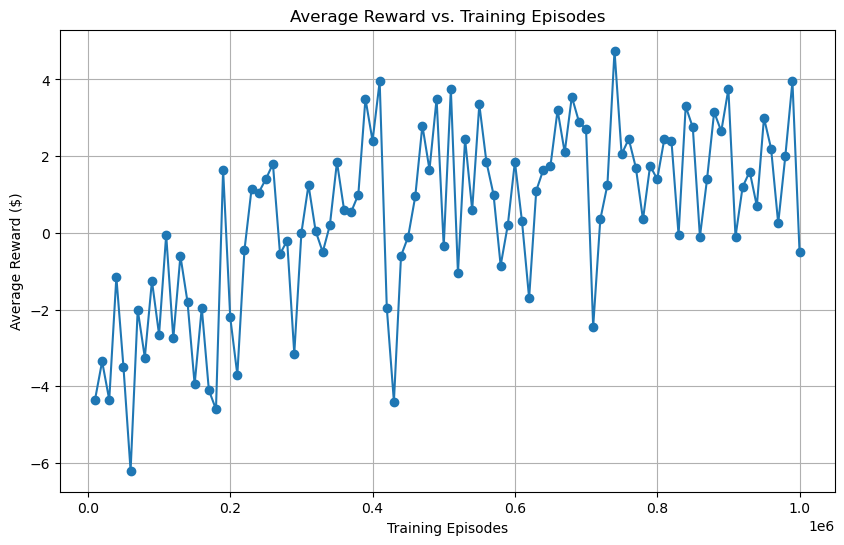

In [ ]:
if __name__ == "__main__":
    import matplotlib.pyplot as plt

    env = SingleDeckBlackjackEnv(base_bet=10)
    agent = QLearningAgent(alpha=0.005, gamma=0.90, epsilon=0.5)

    # Adjust parameters for faster training
    total_episodes = 1000000
    eval_interval = 0.01  # evaluate every 1% of episodes
    eval_episodes = 100   # fewer episodes for each evaluation

    print("Training with adjusted evaluation frequency and fewer eval episodes...")
    agent, eval_episodes_list, eval_rewards = train_qlearning_with_evaluation(
        env,
        agent,
        total_episodes=total_episodes,
        eval_interval=eval_interval,
        eval_episodes=eval_episodes,
        min_epsilon=0.01,
        decay_rate=0.995,
        max_steps_per_episode=10000000
    )

    # Plot learning curve
    plt.figure(figsize=(10, 6))
    plt.plot(eval_episodes_list, eval_rewards, marker='o')
    plt.title("Average Reward vs. Training Episodes")
    plt.xlabel("Training Episodes")
    plt.ylabel("Average Reward ($)")
    plt.grid(True)
    plt.show()


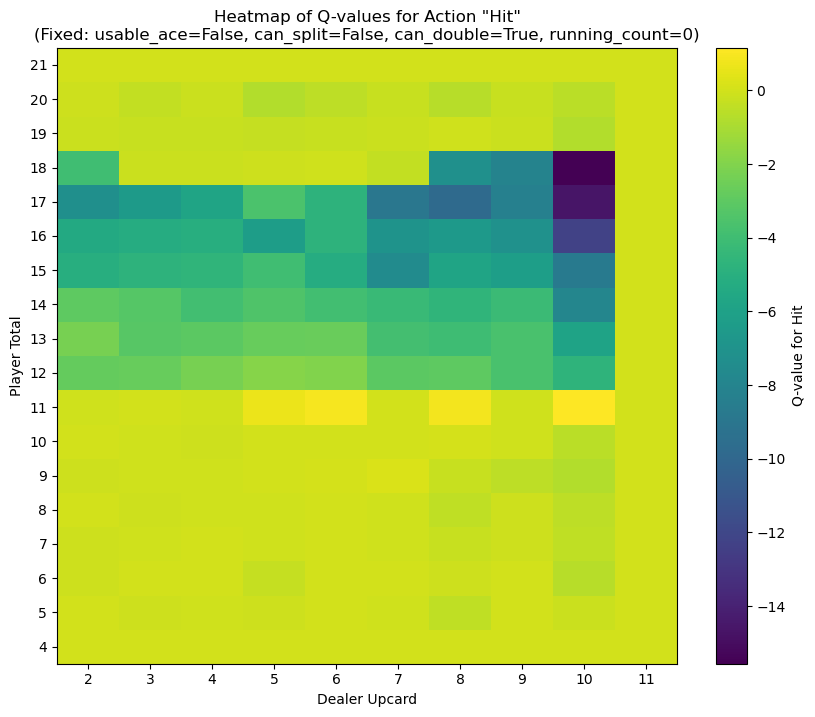

In [ ]:
plot_q_values_for_hit(agent)

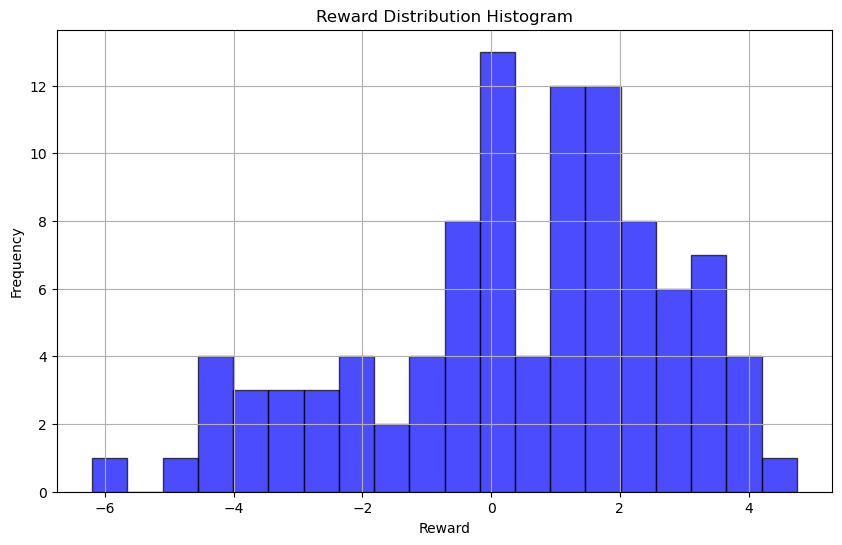

In [ ]:
import matplotlib.pyplot as plt

def plot_reward_histogram(eval_rewards, bins=20):
    """
    Plot a histogram of rewards.

    :param rewards: List of reward values.
    :param bins: Number of bins for the histogram.
    """
    plt.figure(figsize=(10, 6))
    plt.hist(eval_rewards, bins=bins, color='blue', edgecolor='black', alpha=0.7)
    plt.title('Reward Distribution Histogram')
    plt.xlabel('Reward')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Example usage:
# Assuming you have a list of rewards from evaluation or training episodes


plot_reward_histogram(eval_rewards, bins=20)


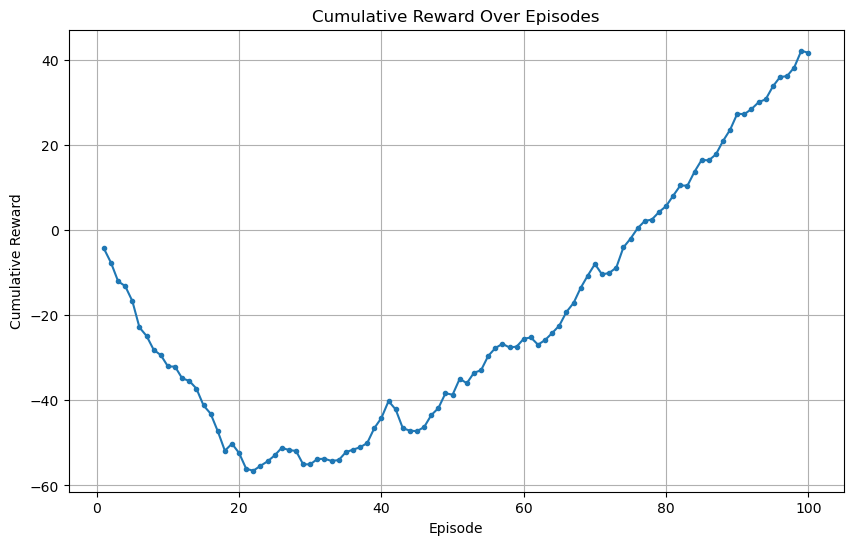

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_cumulative_rewards(eval_rewards):
    """
    Plot the cumulative sum of rewards over episodes.

    :param rewards: List of reward values obtained per episode.
    """
    # Calculate cumulative rewards
    cumulative_rewards = np.cumsum(eval_rewards)

    # Create a plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cumulative_rewards) + 1), cumulative_rewards, marker='.', linestyle='-')
    plt.title('Cumulative Reward Over Episodes')
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.grid(True)
    plt.show()



plot_cumulative_rewards(eval_rewards)
